In [4]:
import torch
import matplotlib.pyplot as plt
from network import UNet, ShallowNet
from dataset import HMP_Dataset, HMP_Lying_Dataset, ShallowDataset
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import os 

In [2]:
# Limb length finder function

def find_limb_length(j_out):
    
    joint_dist_mat = np.zeros((18,18))
        
    neighbors = {
        0: [1,14,15], 
        1: [2,5,8,11], 
        2: [3], 
        3: [4], 
        5: [6], 
        6: [7], 
        8: [9], 
        9: [10], 
        11: [12],
        12: [13], 
        14: [16], 
        15: [17]
    }

    for point in neighbors:
        
        f_p = np.argwhere(j_out == point+1)
        
        if len(f_p) > 0:
            f_p = f_p.mean(axis=0)

            for neighbor in neighbors[point]:
                if neighbor+1 in j_out:
                    s_p = np.argwhere(j_out == neighbor+1).mean(axis=0)
                    joint_dist_mat[point, neighbor] = np.sqrt(np.sum(np.power(f_p-s_p,2)))

    return joint_dist_mat

# Test Set Scores for Deep Models

In [3]:
# Change here for lying kids !

# Standing Kids Test Set

HEIGHT_MEAN = 91.90
WEIGHT_MEAN = 12.54

# Lying Kids Test Set

#HEIGHT_MEAN = 71.49
#WEIGHT_MEAN = 8.11

In [11]:
test = DataLoader(HMP_Dataset('test'), batch_size=1, num_workers=8, shuffle=False)

model = UNet(128)
#model = ShallowNet()
model_dict = torch.load('models/MODEL_16072020_172757_pretrained1/model_ep_51.pth.tar')
model.load_state_dict(model_dict['state_dict'])
model.eval()
model = model.cuda()

res = []

l_h = []
l_w = []

heights = []
weights = []

height_errors = [[] for x in range(6)]
weight_errors = [[] for x in range(5)]

with tqdm(total=len(test), dynamic_ncols=True) as progress:
    with torch.no_grad():

        l_h = []
        l_w = []

        for idx, batch_data in enumerate(test):
            X = batch_data['img'].cuda()
            y_h = batch_data['height'].cuda()
            y_w = batch_data['weight'].cuda()

            mask_o, joint_o, height_o, weight_o, tennis_b = model(X)

            heights.append(HEIGHT_MEAN + y_h.item())
            weights.append(WEIGHT_MEAN + y_w.item())
            
            r_error_h = abs((HEIGHT_MEAN + y_h.item()) - (HEIGHT_MEAN + height_o.item()))
            r_error_w = abs((WEIGHT_MEAN + y_w.item()) - (WEIGHT_MEAN + weight_o.item()))
            
            l_h.append(r_error_h)
            l_w.append(r_error_w)
            
            progress.update(1)

In [13]:
print("Height Error (MAE): {:.2f} cm\nWeight Error (MAE): {:.2f} kg".format(np.mean(l_h), np.mean(l_w)))

Height Error (MAE): 2.91 cm
Weight Error (MAE): 1.10 kg


***

## Error Histogram in Different Height / Weight Groups

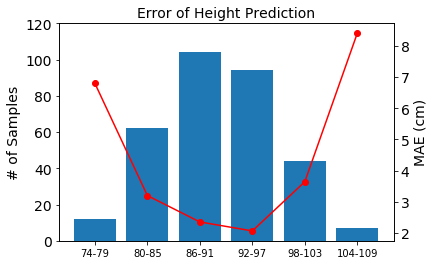

In [168]:
plt.ylim(0, 120)
plt.bar(np.arange(6), [len(x) for x in height_errors])
plt.ylabel('# of Samples', fontsize=14)
plt.title('Error of Height Prediction', fontsize=14)
plt.yticks(fontsize=14)

axes2 = plt.twinx()
axes2.plot([np.mean(x) for x in height_errors], color='r', marker='o')


_ = plt.xticks(
    np.arange(6), 
    ('74-79', '80-85', '86-91', '92-97', '98-103', '104-109'),
    rotation=45,
    fontsize=14
)

_ = plt.yticks(fontsize=14)

axes2.set_ylabel('MAE (cm)', fontsize=14)
plt.savefig('height_error.pdf', dpi=50, bbox_inches='tight')

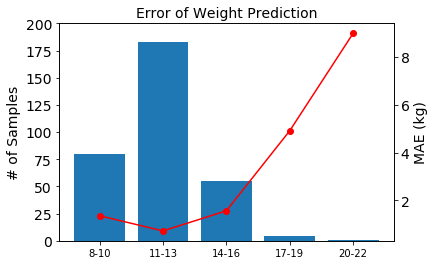

In [167]:
plt.ylim(0, 200)
plt.bar(np.arange(5), [len(x) for x in weight_errors])
plt.ylabel('# of Samples', fontsize=14)
plt.title('Error of Weight Prediction', fontsize=14)
plt.yticks(fontsize=14)

axes2 = plt.twinx()
axes2.plot([np.mean(x) for x in weight_errors], color='r', marker='o')

_ = plt.xticks(
    np.arange(5), 
    ('8-10', '11-13', '14-16', '17-19', '20-22'),
    rotation=45,
    fontsize=14
)

_ = plt.yticks(fontsize=14)

axes2.set_ylabel('MAE (kg)', fontsize=14)
plt.savefig('weight_error.pdf', dpi=50, bbox_inches='tight')

***

## Visualize the Training Process

In [4]:
obj = torch.load('models/SHALLOW_MODEL_26082020_091308_pretrained0/last_model_ep_50.pth.tar')
m_pretrain_dict = obj

p_tl = m_pretrain_dict['t_l']
p_tm = m_pretrain_dict['t_m']
p_tj = m_pretrain_dict['t_j']
p_th = m_pretrain_dict['t_h']
p_tt = m_pretrain_dict['t_t']
p_tw = m_pretrain_dict['t_w']

p_vl = m_pretrain_dict['v_l']
p_vm = m_pretrain_dict['v_m']
p_vj = m_pretrain_dict['v_j']
p_vh = m_pretrain_dict['v_h']
p_vt = m_pretrain_dict['v_t']
p_vw = m_pretrain_dict['v_w']

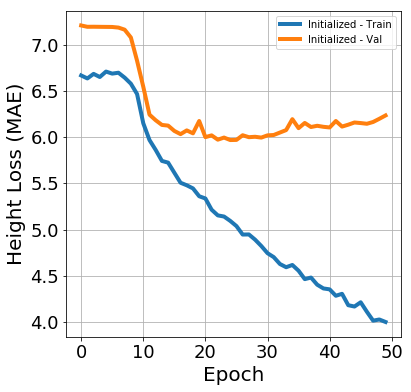

In [5]:
plt.figure(figsize=(6,6))

#plt.plot(s_th, label='Not Initialized - Train', linewidth=4, linestyle='dotted')
#plt.plot(s_vh, label='Not Initialized - Val', linewidth=4, linestyle='dotted')

plt.plot(p_tl, label='Initialized - Train', linewidth=4)
plt.plot(p_vl, label='Initialized - Val', linewidth=4)

plt.tick_params(labelsize=18)
plt.tick_params(labelsize=18)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Height Loss (MAE)', fontsize=20)
plt.legend()
plt.grid()
#plt.savefig('height_loss.png', dpi=50, bbox_inches='tight')